In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from cmdstanpy import CmdStanModel
from baynes.plotter import FitPlotter
from baynes.model_utils import get_stan_file
import pandas as pd
from scipy import stats
sns.set_style('ticks')

sns.set_context("notebook", font_scale=1.6)
plt.rc("axes.spines", top=False, right=False)
import cmdstanpy
import logging
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import arviz as az

#plt.style.use('rose-pine-dawn')

# Example 1: fit of a poissonian process
### Generate the data

### Compile and print the STAN model


In [2]:
stan_file = get_stan_file('poisson_SBC.stan')
model = CmdStanModel(stan_file=stan_file,
                     cpp_options={'STAN_THREADS': True, 'jN': 4})
print(model.code())

Found .stan file  /home/pietro/work/TESI/baynes/stan/models/poisson/poisson_SBC.stan
data {
  int<lower=0> N;
  real alpha;
  real beta;
  real alpha_true;
  real beta_true;
}
transformed data {
  real<lower = 0> lambda_sim = gamma_rng(alpha_true, beta_true);
  array[N] int<lower = 0> y = poisson_rng(rep_array(lambda_sim, N));
}
parameters {
  real<lower=0> lambda;
}
model {
  lambda ~ gamma(alpha, beta);
  y ~ poisson(lambda);
}
generated quantities {
  int<lower = 0, upper = 1> lt_lambda  = lambda < lambda_sim;
}


In [3]:
from baynes.analysis import multithreaded_run

In [4]:
def SBC_plot(data, n_bins, percs=[0.05, 0.95]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    hist.set_titles("")
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='grey', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='grey', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

def ECDF_plot(data, n_bins, percs=[0.05, 0.95]):
    if isinstance(data, str):
        data = pd.read_json(data)
    elif isinstance(data, dict):
        data = pd.DataFrame.from_dict(data)
    hist = sns.displot(data.melt(value_name='rank'), bins=n_bins, kind='hist', x='rank', col='variable', hue='variable', col_wrap=2, alpha=1)
    pdf = stats.binom(len(data), 1/n_bins)
    
    for ax in hist.axes.flatten():
        xlim = ax.get_xlim()
        ax.fill_between(ax.get_xlim(), pdf.ppf(percs[0]), pdf.ppf(percs[1]), color='green', alpha=0.20, zorder=0)
        ax.axhline(pdf.median(), color='green', alpha=0.50, zorder=0)
        ax.set_xlim(xlim)
        ax.grid(visible=False)
    return hist

In [5]:
def run_SBC(model):
    data = {'N': 500, 'alpha':5, 'beta':1, 'alpha_true':5, 'beta_true':1}
    fit = model.sample(data,
                         chains=1,
                         iter_warmup=200,
                         iter_sampling=398,
                         save_warmup=False,
                         show_progress=False,
                         thin=2)
    df = fit.draws_pd('lt_lambda')
    rank = np.sum(df.to_numpy())
    return rank
rank = multithreaded_run(run_SBC, [model]*400, 4)


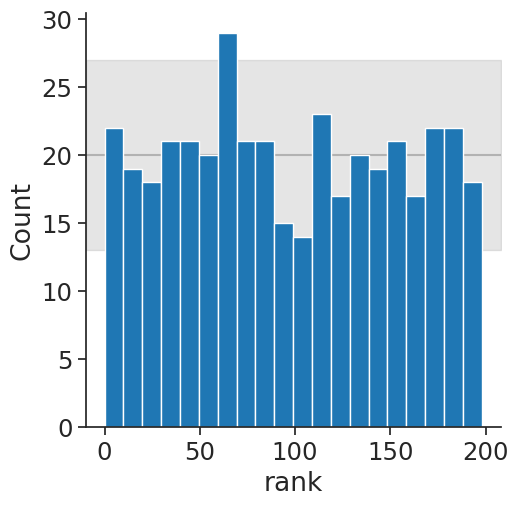

In [6]:
fplot = FitPlotter(output_dir="/home/pietro/work/TESI/thesis/figures/ch2/poisson/", output_format='.pdf')
hist = SBC_plot({'lambda':rank}, 20)
fplot.new_figure('SBChist', hist.figure)
fplot.resize(10,6)


In [7]:
pdf = stats.uniform(0,200)

ax = fplot.new_figure('SBCecdf').subplots()
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, ax=ax, plot_kwargs={}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)
fplot.resize(8,6)
fplot.save_figures('all')

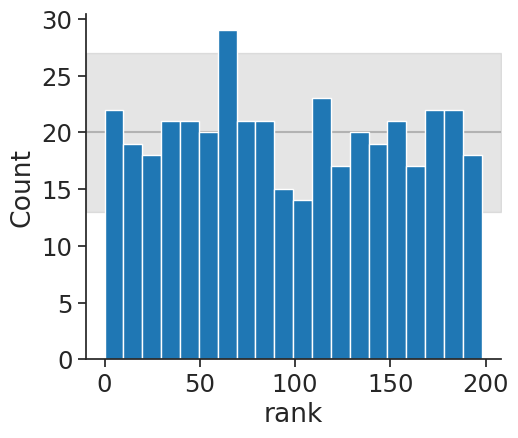

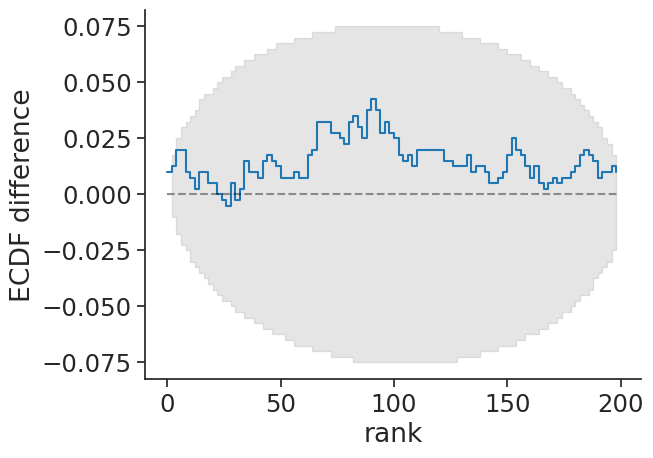

In [8]:

SBC_plot({'lambda':rank}, 20)
pdf = stats.uniform(0,200)
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, plot_kwargs={}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)


In [9]:
exp = len(rank)/20
counts, bins=np.histogram(rank, bins=20)
chi_test = sum([(a-exp)**2/exp for a in counts])

In [10]:
chi_test

9.799999999999997

In [11]:
stats.chi2.sf(chi_test, 20)

0.9716551613077861

In [12]:
chi_test

9.799999999999997

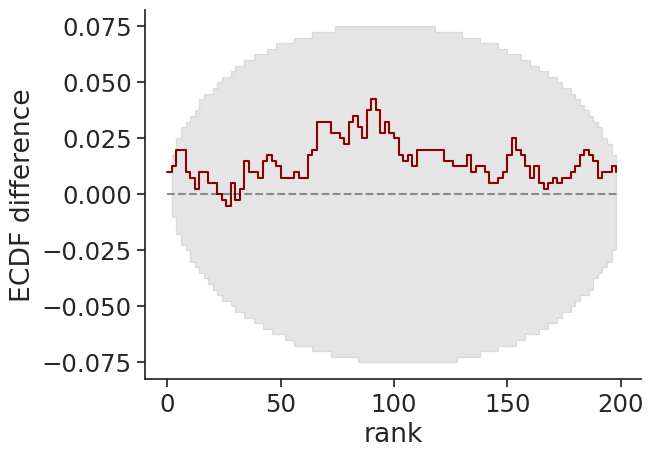

In [13]:
pdf = stats.uniform(0,200)
ax = az.plot_ecdf(rank, cdf = pdf.cdf, difference=True, plot_kwargs={'color': 'darkred'}, fill_kwargs={'color': 'grey'})
ax.set_xlabel('rank')
ax.set_ylabel('ECDF difference')
ax.plot([0]*200, ls='--', color='black', alpha=0.4)

(array([  2.,   0.,   7.,  13.,  14.,  32.,  59.,  95., 137., 200., 257.,
        322., 374., 402., 514., 477., 556., 560., 583., 623., 566., 537.,
        515., 430., 409., 378., 331., 286., 256., 196., 177., 161., 106.,
         93.,  68.,  59.,  44.,  46.,  30.,  25.,  16.,   9.,  12.,   9.,
          2.,   2.,   3.,   2.,   3.,   2.]),
 array([ 6.9161005 ,  7.563433  ,  8.2107655 ,  8.858098  ,  9.5054305 ,
        10.152763  , 10.8000955 , 11.447428  , 12.0947605 , 12.742093  ,
        13.3894255 , 14.036758  , 14.6840905 , 15.331423  , 15.9787555 ,
        16.626088  , 17.2734205 , 17.920753  , 18.5680855 , 19.215418  ,
        19.8627505 , 20.510083  , 21.1574155 , 21.804748  , 22.4520805 ,
        23.099413  , 23.7467455 , 24.394078  , 25.04141051, 25.68874301,
        26.33607551, 26.98340801, 27.63074051, 28.27807301, 28.92540551,
        29.57273801, 30.22007051, 30.86740301, 31.51473551, 32.16206801,
        32.80940051, 33.45673301, 34.10406551, 34.75139801, 35.39873051,
 

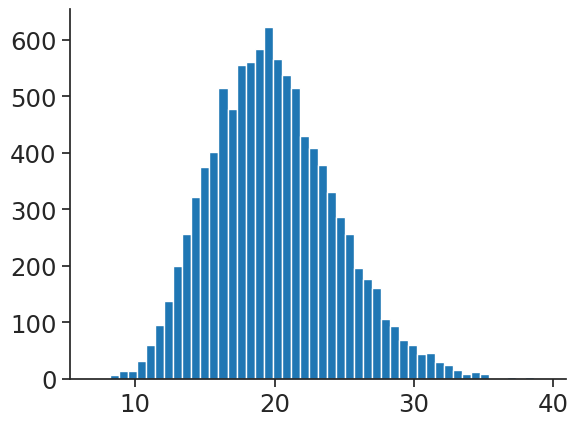

In [14]:
plt.hist(np.random.gamma(20,1, 10000), bins=50)